In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import display
import re

In [2]:
# Payload File Path & Import
base_dir = r'M:/Risk Management/DW/TUX Scorecard/'
subfile_dir = 'Thresholds/Threshold Testing/Input Files/'
filename = '20251104_Run_20250917PlusPayloads.xlsx'

In [3]:
file_path = os.path.join(base_dir, subfile_dir, filename)

In [4]:
df = pd.read_excel(file_path)

In [ ]:
# # AD + Income File Path & Import
# base_dir2 = r'M:/Risk Management/DW/TUX Scorecard/'
# subfile_dir2 = 'Thresholds/Threshold Testing/Input Files/Batch_Files_20251017/'
# filename2 = 'AppLEvel_Income_ADwith20_BatchThresholds_20251022.xlsx'

In [ ]:
# file_path2 = os.path.join(base_dir2, subfile_dir2, filename2)

In [ ]:
# df2 = pd.read_excel(file_path2)

In [5]:
print(f"Rows in Payload Data {len(df)}")

Rows in Payload Data 78863


In [ ]:
# print(f"Rows in AD_Income Data {len(df2)}")

In [ ]:
# # extract debtor id from id column in df

# def extract_debtorid(value):
#     s = str(value)
#     # remove the ' value if it exists at the front of the id string value
#     if s.startswith("'"):
#         s = s[1:]
#     # Then extract characters 7–15
#     return s[7:15]

# df['DebtorID'] = df['id'].apply(extract_debtorid)

In [ ]:
# # Set debtor id as int

# df['DebtorID'] = pd.to_numeric(df['DebtorID'], errors='coerce').astype('Int64')

In [ ]:
# # Extract applicant and create index for debtor/codebtor

# def extract_applicant_index(value):
#     s = str(value)
#     # Remove the leading single quote if present
#     if s.startswith("'"):
#         s = s[1:]
#     # Return the last character (0 or 1)
#     return s[-1]

# df['Applicant_Index'] = df['id'].apply(extract_applicant_index).astype('Int64')

In [ ]:
# # Set debtor id data type to drop .0 format

# df2['DEBTOR_ID'] = df2['DEBTOR_ID'].astype(float).apply(lambda x: int(x) if pd.notna(x) else pd.NA)
# df2['DEBTOR_ID'] = df2['DEBTOR_ID'].astype('Int64')


# df2['CODEBTOR_ID'] = df2['CODEBTOR_ID'].astype(float).apply(lambda x: int(x) if pd.notna(x) else pd.NA)
# df2['CODEBTOR_ID'] = df2['CODEBTOR_ID'].astype('Int64')

In [6]:
# Application credit profile extraction from status message when it doesn't exist in ApplicationCreditProfileType

profile = ["ThickDirty", "Thin", "ThickClean", "OpenBK"]

def extract_credit_profile(status_msg):
    if pd.isna(status_msg):
        return np.nan
    for word in profile:
        if word.lower() in status_msg.lower():
            return word
    return np.nan

# Extract profile type into a temp column
df['ExtractedProfile'] = df['APPLICANT_STATUS_MESSAGE'].apply(extract_credit_profile)

# Fill ApplicationCreditProfileType when missing
df['APPLICATION_CREDIT_PROFILE_TYPE'] = np.where(
    df['APPLICATION_CREDIT_PROFILE_TYPE'].isna() | (df['APPLICATION_CREDIT_PROFILE_TYPE'].str.strip() == ''),
    df['ExtractedProfile'],
    df['APPLICATION_CREDIT_PROFILE_TYPE']
)

In [7]:
# Drop temp column

df.drop(columns='ExtractedProfile', inplace=True)

In [8]:
# Extract application score from status message and impute on application score when it's nan or 0
def extract_score(status_msg):
    if pd.isna(status_msg):
        return np.nan
    match = re.search(r'(\b\d{3,4}\b)', status_msg)
    if match:
        return float(match.group(1))
    return np.nan

# Extracted score into a temp column
df['ExtractedScore'] = df['APPLICANT_STATUS_MESSAGE'].apply(extract_score)

# Fill APPLICATION_SCORE when it's nan or 0
df['APPLICATION_SCORE'] = np.where(
    df['APPLICATION_SCORE'].isna() | (df['APPLICATION_SCORE'] == 0),
    df['ExtractedScore'],
    df['APPLICATION_SCORE']
)

In [9]:
# Drop temp helper column
df.drop(columns='ExtractedScore', inplace=True)

In [10]:
print(f"Rows in Payload df before dropping remaining blank/missing credit profiles {len(df)}")

Rows in Payload df before dropping remaining blank/missing credit profiles 78863


In [11]:
print(f"Number of APPLICATION rows in Payload df before dropping remaining credit profiles {len(df[df['APPLICANT_INDEX'] == 1])}")

Number of APPLICATION rows in Payload df before dropping remaining credit profiles 67609


In [12]:
# Drop any remaining rows with no application level credit profiles 

df = df.dropna(subset=['APPLICATION_CREDIT_PROFILE_TYPE'])

In [13]:
print(f"Rows in Payload df after dropping remaining blank/missing credit profiles {len(df)}")

Rows in Payload df after dropping remaining blank/missing credit profiles 77973


In [14]:
print(f"Number of APPLICATION rows in Payload df after dropping remaining credit profiles {len(df[df['APPLICANT_INDEX'] == 1])}")

Number of APPLICATION rows in Payload df after dropping remaining credit profiles 67178


In [ ]:
# # Merge payload df and ad/income df

# df3 = df.merge(df2, how='left', left_on='AccountId', right_on='ACCOUNT_ID')

In [ ]:
# # Drop unnecessary columns

# # df3.drop(columns=['id', 'RequestId', 'RowId', 'SourceFileName', 'ErrorMessage', 'CreditScorecardVersion', 
# #                         'CapacityScorecardVersion', 'ACCOUNT_ID.1'], inplace=True)

# df3.drop(columns=['id', 'RequestId', 'RowId', 'SourceFileName', 'ErrorMessage', 'CreditScorecardVersion', 
#                         'CapacityScorecardVersion'], inplace=True)

In [15]:
print(f"Rows in merged df {len(df)}")

Rows in merged df 77973


In [16]:
print(f"Number of Debtor Application rows in final df after merging {len(df[df['APPLICANT_INDEX'] == 1])}")

print(f"Number of Co-Debtor Application rows in final df after merging {len(df[df['APPLICANT_INDEX'] == 2])}")

Number of Debtor Application rows in final df after merging 67178
Number of Co-Debtor Application rows in final df after merging 10795


In [21]:
# Debtor/Codebtor mix

print(f"Number of DEBTOR Application rows: {(len(df[df['APPLICANT_INDEX'] == 1]) / len(df)):.2%}")

print(f"Number of Co-DEBTOR Application rows: {(len(df[df['APPLICANT_INDEX'] == 2]) / len(df)):.2%}")

Number of DEBTOR Application rows: 86.16%
Number of Co-DEBTOR Application rows: 13.84%


In [ ]:
# with pd.ExcelWriter('M:/Risk Management/DW/TUX Scorecard/Thresholds/Threshold Testing/BatchFile_Thresholds_20251020/test.xlsx', engine='xlsxwriter') as writer:
#     df3.to_excel(writer, sheet_name='Sheet1', index=False)

### Auto Decline Rules Impact

In [22]:
# Filter to applicant only rows 
applicants = df[df['APPLICANT_INDEX'] == 1]

# Total # of applicants by credit profile
total_by_profile = applicants.groupby('APPLICATION_CREDIT_PROFILE_TYPE').size().reset_index(name='Total_Applicants')

# Number of auto-declines by profile
auto_declines_by_profile = applicants[
    (applicants['HITAUTODECLINE_NO14_168'] == 1)
    ].groupby('APPLICATION_CREDIT_PROFILE_TYPE').size().reset_index(name='AutoDecline_Count')

# combine totals
profile_summary = total_by_profile.merge(auto_declines_by_profile, on='APPLICATION_CREDIT_PROFILE_TYPE', how='left')

# Backfill any nans with 0
profile_summary['AutoDecline_Count'] = profile_summary['AutoDecline_Count'].fillna(0).astype(int)

# calc %
profile_summary['AutoDecline_Pct'] = profile_summary['AutoDecline_Count'] / profile_summary['Total_Applicants']

# calc remaining apps
profile_summary['Remaining_Applications'] = profile_summary['Total_Applicants'] - profile_summary['AutoDecline_Count']
profile_summary['PostHC_ApprovalRate'] = profile_summary['Remaining_Applications'] / profile_summary['Total_Applicants']

# Add totals
total_row = pd.DataFrame({
    'APPLICATION_CREDIT_PROFILE_TYPE': ['Total'],
    'Total_Applicants': [profile_summary['Total_Applicants'].sum()],
    'AutoDecline_Count': [profile_summary['AutoDecline_Count'].sum()],
    'Remaining_Applications': [profile_summary['Remaining_Applications'].sum()],
})

# calc weighted average %
total_auto_pct = (profile_summary['AutoDecline_Count'].sum() / profile_summary['Total_Applicants'].sum())
total_remain_pct = (profile_summary['Remaining_Applications'].sum() / profile_summary['Total_Applicants'].sum())

total_row['AutoDecline_Pct'] = total_auto_pct
total_row['PostHC_ApprovalRate'] = total_remain_pct

# Append total row back on
profile_summary = pd.concat([profile_summary, total_row], ignore_index=True)

# Clean up output
profile_summary['Total_Applicants'] = profile_summary['Total_Applicants'].map('{:,}'.format)
profile_summary['AutoDecline_Count'] = profile_summary['AutoDecline_Count'].map('{:,}'.format)
profile_summary['Remaining_Applications'] = profile_summary['Remaining_Applications'].map('{:,}'.format)
profile_summary['AutoDecline_Pct'] = profile_summary['AutoDecline_Pct'].apply(lambda x: f"{x:.2%}")
profile_summary['PostHC_ApprovalRate'] = profile_summary['PostHC_ApprovalRate'].apply(lambda x: f"{x:.2%}")

# Sort descending by AutoDecline_Pct
profile_summary_display = pd.concat([
    profile_summary[profile_summary['APPLICATION_CREDIT_PROFILE_TYPE'] != 'Total'].sort_values(
        'AutoDecline_Pct', ascending=False),
    profile_summary[profile_summary['APPLICATION_CREDIT_PROFILE_TYPE'] == 'Total']
], ignore_index=True)

# print
display(profile_summary_display)


,APPLICATION_CREDIT_PROFILE_TYPE,Total_Applicants,AutoDecline_Count,AutoDecline_Pct,Remaining_Applications,PostHC_ApprovalRate
0,Unscoreable,"2,462","2,457",99.80%,5,0.20%
1,ThickDirty,"28,542","14,583",51.09%,"13,959",48.91%
2,Thin,"21,899","10,207",46.61%,"11,692",53.39%
3,ThickClean,"8,055","2,374",29.47%,"5,681",70.53%
4,OpenBK,"6,220",906,14.57%,"5,314",85.43%
5,Total,"67,178","30,527",45.44%,"36,651",54.56%


#### Post Credit Declines

In [23]:
ct_postcredit_declines = (df['BITPOSTCREDIT_NO14_168'] == 1).sum()
print(f"Number of rows hitting post-credit auto decline rules: {ct_postcredit_declines}")

Number of rows hitting post-credit auto decline rules: 35403


In [24]:
# Filter to applicant rows 
applicants = df[df['APPLICANT_INDEX'] == 1]

# Total # of applicants by profile
total_by_profile = applicants.groupby('APPLICATION_CREDIT_PROFILE_TYPE').size().reset_index(name='Total_Applicants')

# Number of auto-declines by profile
auto_declines_by_profile = applicants[
    (applicants['BITPOSTCREDIT_NO14_168'] == 1)
    ].groupby('APPLICATION_CREDIT_PROFILE_TYPE').size().reset_index(name='PostCredit_Decline_Count')

# Merge totals and filtered counts
profile_summary = total_by_profile.merge(auto_declines_by_profile, on='APPLICATION_CREDIT_PROFILE_TYPE', how='left')

# Fill NaN counts with 0
profile_summary['PostCredit_Decline_Count'] = profile_summary['PostCredit_Decline_Count'].fillna(0).astype(int)

# Calculate percentages
profile_summary['PostCredit_Decline_Pct'] = profile_summary['PostCredit_Decline_Count'] / profile_summary['Total_Applicants']

# Calculate remaining applications
profile_summary['Remaining_Applications'] = profile_summary['Total_Applicants'] - profile_summary['PostCredit_Decline_Count']
profile_summary['PostHC_ApprovalRate'] = profile_summary['Remaining_Applications'] / profile_summary['Total_Applicants']

# Add Total row
total_row = pd.DataFrame({
    'APPLICATION_CREDIT_PROFILE_TYPE': ['Total'],
    'Total_Applicants': [profile_summary['Total_Applicants'].sum()],
    'PostCredit_Decline_Count': [profile_summary['PostCredit_Decline_Count'].sum()],
    'Remaining_Applications': [profile_summary['Remaining_Applications'].sum()],
})

# Compute weighted average percentages
total_auto_pct = (profile_summary['PostCredit_Decline_Count'].sum() / profile_summary['Total_Applicants'].sum())
total_remain_pct = (profile_summary['Remaining_Applications'].sum() / profile_summary['Total_Applicants'].sum())

total_row['PostCredit_Decline_Pct'] = total_auto_pct
total_row['PostHC_ApprovalRate'] = total_remain_pct

# Append total row
profile_summary = pd.concat([profile_summary, total_row], ignore_index=True)

# Beautify numbers for display
profile_summary['Total_Applicants'] = profile_summary['Total_Applicants'].map('{:,}'.format)
profile_summary['PostCredit_Decline_Count'] = profile_summary['PostCredit_Decline_Count'].map('{:,}'.format)
profile_summary['Remaining_Applications'] = profile_summary['Remaining_Applications'].map('{:,}'.format)
profile_summary['PostCredit_Decline_Pct'] = profile_summary['PostCredit_Decline_Pct'].apply(lambda x: f"{x:.2%}")
profile_summary['PostHC_ApprovalRate'] = profile_summary['PostHC_ApprovalRate'].apply(lambda x: f"{x:.2%}")

# Sort descending by AutoDecline_Pct (excluding Total row)
profile_summary_display = pd.concat([
    profile_summary[profile_summary['APPLICATION_CREDIT_PROFILE_TYPE'] != 'Total'].sort_values(
        'PostCredit_Decline_Pct', ascending=False),
    profile_summary[profile_summary['APPLICATION_CREDIT_PROFILE_TYPE'] == 'Total']
], ignore_index=True)

# Display nicely
display(profile_summary_display)


,APPLICATION_CREDIT_PROFILE_TYPE,Total_Applicants,PostCredit_Decline_Count,PostCredit_Decline_Pct,Remaining_Applications,PostHC_ApprovalRate
0,Unscoreable,"2,462","2,452",99.59%,10,0.41%
1,ThickDirty,"28,542","14,287",50.06%,"14,255",49.94%
2,Thin,"21,899","9,940",45.39%,"11,959",54.61%
3,ThickClean,"8,055","2,186",27.14%,"5,869",72.86%
4,OpenBK,"6,220",729,11.72%,"5,491",88.28%
5,Total,"67,178","29,594",44.05%,"37,584",55.95%


#### Drop Auto Declines

In [25]:
df = df.drop(df[df['HITAUTODECLINE_NO14_168'] == 1].index)#, inplace=True)

In [26]:
ct_remaining = len(df)
print(f"Number of rows after dropping all auto declines: {ct_remaining}")

Number of rows after dropping all auto declines: 41500


### Pivot Mean Applicant Score - Regardless of Outcome

In [28]:
# Pivot showing the avg TUX equalized score for the applicant pivot table
AvgCrScore_DebtorType = pd.pivot_table(df, 
                                    values=['APPLICANT_EQUALIZED_SCORE'],
                                    index='APPLICATION_CREDIT_PROFILE_TYPE',
                                    # columns='bitPrimary',
                                    aggfunc='mean',
                                    fill_value=0
                                    )
AvgCrScore_DebtorType = AvgCrScore_DebtorType.astype(int)

AvgCrScore_DebtorType

,APPLICANT_EQUALIZED_SCORE
APPLICATION_CREDIT_PROFILE_TYPE,
OpenBK,674
ThickClean,657
ThickDirty,656
Thin,626
Unscoreable,300


In [29]:
# Pivot showing the avg TUX score for the application
AvgScore_Application = pd.pivot_table(df, 
                                    values=['APPLICATION_SCORE'],
                                    index='APPLICATION_CREDIT_PROFILE_TYPE',
                                    aggfunc='mean',
                                    fill_value=0
                                    )
AvgScore_Application = AvgScore_Application.astype(int)

AvgScore_Application

,APPLICATION_SCORE
APPLICATION_CREDIT_PROFILE_TYPE,
OpenBK,677
ThickClean,657
ThickDirty,654
Thin,622
Unscoreable,2025


In [31]:
# Pivot showing the avg TUX score for the application
Count_Application = pd.pivot_table(df, 
                                    values=['ACCOUNTID'],
                                    index='APPLICATION_CREDIT_PROFILE_TYPE',
                                    aggfunc='count',
                                    fill_value=0
                                    )
Count_Application = Count_Application.astype(int)

Count_Application

,ACCOUNTID
APPLICATION_CREDIT_PROFILE_TYPE,
OpenBK,5937
ThickClean,6363
ThickDirty,15710
Thin,13485
Unscoreable,5


In [32]:
# Drop "Unscoreable" rows for threshold deciling

df = df[df['APPLICATION_CREDIT_PROFILE_TYPE'] != 'Unscoreable']

In [33]:
count_remain = len(df)
print(f"Number of rows after dropping all auto declines: {count_remain}")

Number of rows after dropping all auto declines: 41495


In [ ]:
# Drop "0" (Decline) score rows before deciling

In [34]:
df = df[df['APPLICATION_SCORE'] != 0]

In [35]:
number_left = len(df)
print(f"Number of rows after dropping all auto declines: {number_left}")

Number of rows after dropping all auto declines: 41495


### Graph decile distributions of "scored" application level data

In [36]:
# Decile distribution plots

def plot_segmented_distributions10(df, score_col, segment_col, output_dir):

    # df = df[df['Applicant_Index'] == 1].copy()
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Dictionary to store quantiles for each segment
    quantiles = {}
    for segment in df[segment_col].unique():
        quantiles[segment] = df[df[segment_col] == segment][score_col].quantile(
            [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    # New column to store quantiles
    df['EQScore_Decile10'] = df.groupby(segment_col)[score_col].transform(
        lambda x: pd.qcut(
            x,
            q=10,
            labels=[
                "Q1 (0-10%)", "Q2 (10-20%)", "Q3 (20-30%)", "Q4 (30-40%)", "Q5 (40-50%)", "Q6 (50-60%)", "Q7 (60-70%)", 
                "Q8 (70-80%)", "Q9 (80-90%)", "Q10 (90-100%)"], duplicates='drop'))

    # Get all unique segment values
    unique_segments = df[segment_col].unique()

    for segment in unique_segments:
        # Filter data for current segment
        segment_data = df[df[segment_col] == segment]
        
        # Get quantile values
        quantile_values = quantiles[segment]
        
        # Graph plot
        plt.figure(figsize=(12, 6))
        sns.histplot(segment_data[score_col], bins=20, kde=True, color='royalblue')

        # Add vertical lines for each quantile
        colors = sns.color_palette("husl", 9)
        for idx, q in enumerate(quantile_values.index):
            value = quantile_values[q]
            if pd.notna(value):
                label = f'{int(q*100)}%: {int(value)}'
            else:
                label = f'{int(q*100)}%: n/a'
                value = segment_data[score_col].mean()  # fallback line

            plt.axvline(
                value,
                color=colors[idx % len(colors)],
                linestyle='dashed',
                linewidth=1.5,
                label=label
            )

        # Plot mean line
        mean = segment_data[score_col].mean()
        # Add a dummy invisible line just for legend
        plt.plot([], [], color='red', linestyle='dashed', linewidth=2, label=f'Mean (μ): {int(mean)}')

        # Add title + axis labels
        plt.title(f'Distribution of {score_col} for {segment}')
        plt.xlabel(score_col)
        plt.ylabel('Count')

        # Legend
        plt.legend(loc='upper right', fontsize='small')
        
        # Save to file
        file_path = os.path.join(output_dir, f'{segment}_{score_col}_distribution10s.png')
        plt.savefig(file_path)
        plt.show()
        plt.close()

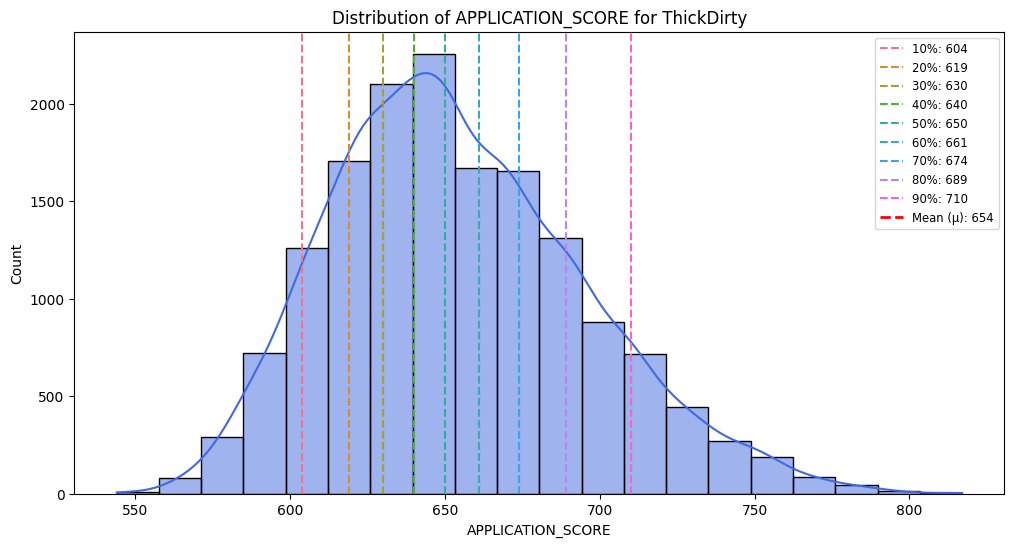

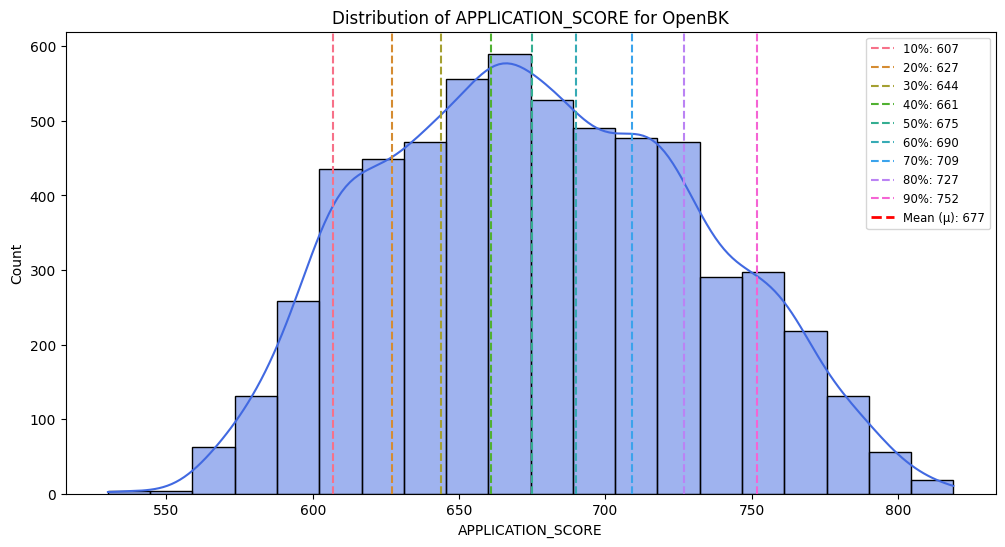

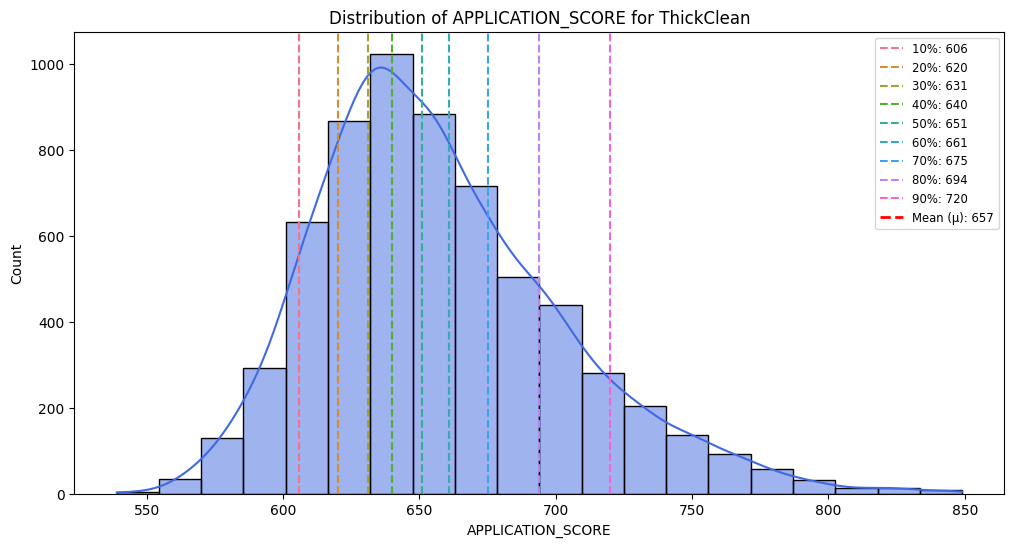

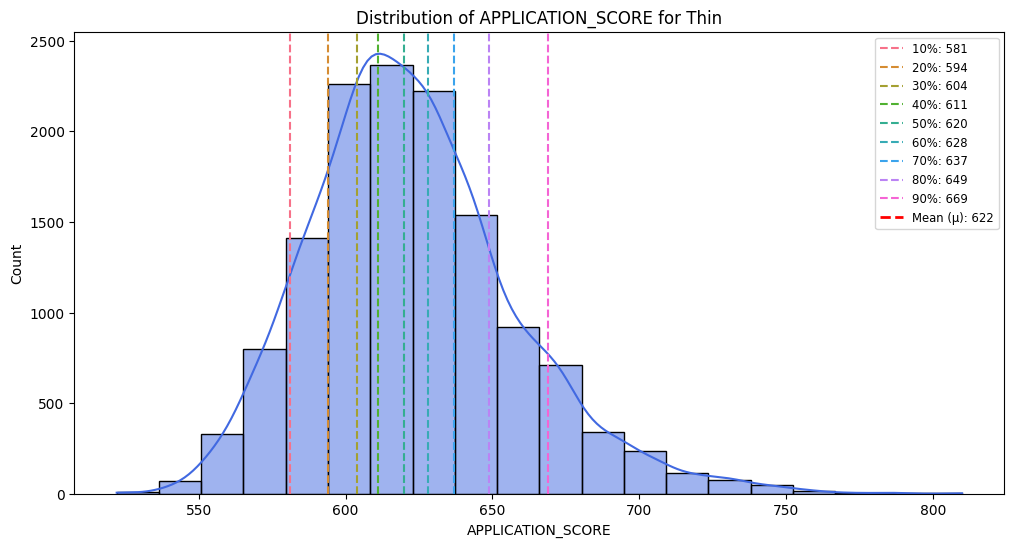

In [38]:
# Call function and export graphs

plot_segmented_distributions10(df, 'APPLICATION_SCORE', 'APPLICATION_CREDIT_PROFILE_TYPE', output_dir=r'M:/Risk Management/DW/TUX Scorecard/Thresholds/Threshold Testing/Output_Graphs/20251104/')

In [45]:
def calculate_decile_summary(df, score_col, segment_col):
    # Define consistent decile labels
    decile_labels = [f"D{i+1} ({i*10}-{(i+1)*10}%)" for i in range(10)]

    # Assign deciles within each segment
    df['EQScore_Decile10'] = df.groupby(segment_col)[score_col].transform(
        lambda x: pd.qcut(x, q=10, labels=decile_labels, duplicates='drop')
    )

    # List to store summary data
    summary_data = []
    for segment in df[segment_col].unique():
        segment_data = df[df[segment_col] == segment]
        for decile in decile_labels:
            decile_data = segment_data[segment_data['EQScore_Decile10'] == decile]
            count = len(decile_data)
            avg_score = round(decile_data[score_col].mean(), 2) if not decile_data.empty else None
            summary_data.append([segment, decile, count, avg_score])

    # Convert to DataFrame
    summary_df = pd.DataFrame(summary_data, columns=[segment_col, 'Decile', 'Count', 'AvgScore'])

    # Pivot tables
    count_table = summary_df.pivot_table(index=segment_col, columns='Decile', values='Count', aggfunc='first')
    avg_score_table = summary_df.pivot_table(index=segment_col, columns='Decile', values='AvgScore', aggfunc='first')

    return count_table, avg_score_table


In [46]:
# Function to display the tables with simple formatting
def display_tables(count_table, avg_score_table):
    
    # Print the count table and average score table
    print("Count Table (Applications per Decile):")
    print(count_table.to_string())
    
    # Print the average score table
    print("\nAverage Score Table (Avg Score per Decile):")
    print(avg_score_table.to_string())  


In [47]:
def add_decile_ranges(df, score_col, segment_col):
    decile_labels = [f"D{i+1} ({i*10}-{(i+1)*10}%)" for i in range(10)]
    ranges = {}

    for segment in df[segment_col].unique():
        segment_data = df[df[segment_col] == segment]
        deciles = segment_data[score_col].quantile([i/10 for i in range(1, 10)]).values
        full_deciles = [segment_data[score_col].min()] + list(deciles) + [segment_data[score_col].max()]

        ranges[segment] = {
            decile_labels[i]: (full_deciles[i], full_deciles[i+1]) for i in range(10)
        }

    return ranges

In [48]:
# Call the function to add ranges
ranges = add_decile_ranges(df, 'APPLICATION_SCORE', 'APPLICATION_CREDIT_PROFILE_TYPE')

# Print the ranges for each decile
for segment, decile_ranges in ranges.items():
    print(f"\nDecile Ranges for {segment}:")
    for decile, (low, high) in decile_ranges.items():
        print(f"{decile}: {low:.0f} - {high:.0f}")


Decile Ranges for ThickDirty:
D1 (0-10%): 544 - 604
D2 (10-20%): 604 - 619
D3 (20-30%): 619 - 630
D4 (30-40%): 630 - 640
D5 (40-50%): 640 - 650
D6 (50-60%): 650 - 661
D7 (60-70%): 661 - 674
D8 (70-80%): 674 - 689
D9 (80-90%): 689 - 710
D10 (90-100%): 710 - 817

Decile Ranges for OpenBK:
D1 (0-10%): 530 - 607
D2 (10-20%): 607 - 627
D3 (20-30%): 627 - 644
D4 (30-40%): 644 - 661
D5 (40-50%): 661 - 675
D6 (50-60%): 675 - 690
D7 (60-70%): 690 - 709
D8 (70-80%): 709 - 727
D9 (80-90%): 727 - 752
D10 (90-100%): 752 - 819

Decile Ranges for ThickClean:
D1 (0-10%): 539 - 606
D2 (10-20%): 606 - 620
D3 (20-30%): 620 - 631
D4 (30-40%): 631 - 640
D5 (40-50%): 640 - 651
D6 (50-60%): 651 - 661
D7 (60-70%): 661 - 675
D8 (70-80%): 675 - 694
D9 (80-90%): 694 - 720
D10 (90-100%): 720 - 849

Decile Ranges for Thin:
D1 (0-10%): 522 - 581
D2 (10-20%): 581 - 594
D3 (20-30%): 594 - 604
D4 (30-40%): 604 - 611
D5 (40-50%): 611 - 620
D6 (50-60%): 620 - 628
D7 (60-70%): 628 - 637
D8 (70-80%): 637 - 649
D9 (80-90%

In [49]:
# Calculate decile summaries
count_table, avg_score_table = calculate_decile_summary(
    df,
    score_col='APPLICATION_SCORE',
    segment_col='APPLICATION_CREDIT_PROFILE_TYPE'
)

# Display tables
display_tables(count_table, avg_score_table)

# Get decile ranges
ranges = add_decile_ranges(df, 'APPLICATION_SCORE', 'APPLICATION_CREDIT_PROFILE_TYPE')

# Print ranges
for segment, decile_ranges in ranges.items():
    print(f"\nDecile Ranges for {segment}:")
    for decile, (low, high) in decile_ranges.items():
        print(f"{decile}: {low:.0f} - {high:.0f}")


Count Table (Applications per Decile):
Decile                           D1 (0-10%)  D10 (90-100%)  D2 (10-20%)  D3 (20-30%)  D4 (30-40%)  D5 (40-50%)  D6 (50-60%)  D7 (60-70%)  D8 (70-80%)  D9 (80-90%)
APPLICATION_CREDIT_PROFILE_TYPE                                                                                                                                   
OpenBK                                  611            582          601          570          630          586          566          611          594          586
ThickClean                              670            625          636          654          632          653          574          639          659          621
ThickDirty                             1585           1567         1643         1578         1544         1591         1528         1638         1505         1531
Thin                                   1390           1347         1368         1445         1201         1505         1255         1304         1

In [50]:
# Generate decile ranges table
decile_rows = []
for segment, decile_ranges in ranges.items():
    for decile, (low, high) in decile_ranges.items():
        decile_rows.append({
            'Segment': segment,
            'Decile': decile,
            'Min Score': round(low, 0),
            'Max Score': round(high, 0)
        })
ranges_df = pd.DataFrame(decile_rows)


# Output filename
output_filename = 'M:/Risk Management/DW/TUX Scorecard/Thresholds/Threshold Testing/Threshold_Outputs/20251104_Application_Thresholds.xlsx'


In [52]:
# -----------------------------
# Convert and ensure numeric decile exists from ranges_df table
# -----------------------------
df['Decile_Num'] = df['EQScore_Decile10'].str.extract(r'D(\d+)').astype(int)

In [ ]:
# # Function to call if we want to expand % based on deciles across all segments.
# # Doesn't allow customization of segment/decile/percent individually

# # -----------------------------
# # Define Input Changes
# # -----------------------------

# # Define segments and the % to expand
# expansion_settings = {
#     'OpenBK': 20,
#     'ThickClean': 10
#     # 'ThickDirty': 7,
#     # 'Thin': 5
# }

# # Define Deciles to expand
# deciles_to_expand = [10] # [2,3,4,5,6,7,8,9,10]

# # -----------------------------
# # Convert and ensure numeric decile exists from ranges_df table
# # -----------------------------
# df3['Decile_Num'] = df3['EQScore_Decile10'].str.extract(r'D(\d+)').astype(int)

# # -----------------------------
# # Expansion function 
# # -----------------------------
# def generate_multi_segment_table(df, score_col, decile_col, segment_col,
#                                  segments_dict, deciles):
#     all_records = []

#     for segment, expansion_pct in segments_dict.items():
#         df_seg = df[df[segment_col] == segment].copy()

#         for decile in deciles:
#             target_data = df_seg[df_seg[decile_col] == decile]
#             current_count = len(target_data)
#             desired_add = int(round(current_count * expansion_pct / 100))

#             # min/max scores in current decile
#             decile_min = target_data[score_col].min()
#             decile_max = target_data[score_col].max()

#             # data in lower decile
#             lower_decile = decile - 1
#             lower_data = df_seg[df_seg[decile_col] == lower_decile].sort_values(
#                 score_col, ascending=False
#             )

#             if lower_data.empty or desired_add == 0:
#                 actual_add = 0
#                 new_cutoff = None
#             else:
#                 actual_add = min(desired_add, len(lower_data))
#                 new_cutoff = lower_data[score_col].iloc[actual_add-1]

#             # new min score if cutoff applied
#             new_min_score = min(decile_min, new_cutoff) if new_cutoff is not None else decile_min

#             new_decile_count = current_count + actual_add
#             total_count = len(df_seg)
#             new_decile_pct = round(new_decile_count / total_count * 100, 2)

#             all_records.append({
#                 'Segment': segment,
#                 'TargetDecile': decile,
#                 'CurrentDecileCount': current_count,
#                 'AdditionalAppsIfAdjusted': actual_add,
#                 'CurrentDecileMinScore': decile_min,
#                 'CurrentDecileMaxScore': decile_max,
#                 'SuggestedCutoffForNewPercentage': new_cutoff,
#                 'NewMinScore': new_min_score,
#                 'ExpansionPctApplied': expansion_pct,
#                 'NewDecilePct': new_decile_pct
#             })

#     return pd.DataFrame(all_records)

# # -----------------------------
# # Generate table
# # -----------------------------
# multi_segment_table = generate_multi_segment_table(
#     df=df3,
#     score_col='ApplicationScore',
#     decile_col='Decile_Num',
#     segment_col='ApplicationCreditProfileType',
#     segments_dict=expansion_settings,
#     deciles=deciles_to_expand
# )

# # -----------------------------
# # Call table function
# # -----------------------------
# display(multi_segment_table)


In [53]:
# Set the Decile (left) and Percent to expand that decile too (right) for each segment desired
# I.E. 'OpenBK': {10: 20} is decile 10 by 20%

expansion_settings = {
    'OpenBK': {8: 20, 10: 20},
    'ThickClean': {8: 10, 9: 15, 10: 20},
    # 'ThickDirty': {10: 10},
    # 'Thin': {10: 05}
}


In [54]:
# Function to apply change in decile percent desired and return proposed decile score ranges based on request

"""
Purpose: Define the segment + decile(s) + percent change desired for that decile
Return table showing updated min/max score ranges for that segment/decile/score range
Returns current count of apps, increase count of apps from change, current min/max scores of deciles/ranges, 
    the new minimum score for that decile based on the % applied, expansion % applied to that segment/decile, 
    and the new % concentration of that decile

"""


def generate_multi_segment_table(df, score_col, decile_col, segment_col, segments_dict):
    # Create empty list for all record changes
    all_records = []
    # Iterate through dictionary for segment and decile expansion items
    for segment, decile_expansions in segments_dict.items():
        df_seg = df[df[segment_col] == segment].copy()
        # Calc the percent change requested and apply % change to decile range, iterate through all requested in parameter setting. 
        for decile, expansion_pct in decile_expansions.items():
            target_data = df_seg[df_seg[decile_col] == decile]
            current_count = len(target_data)
            desired_add = int(round(current_count * expansion_pct / 100))
            # Return the current min/max scores
            decile_min = target_data[score_col].min()
            decile_max = target_data[score_col].max()
            # Determine the # to pull from lower decile for requested % 
            lower_decile = decile - 1
            lower_data = df_seg[df_seg[decile_col] == lower_decile].sort_values(
                score_col, ascending=False
            )

            if lower_data.empty or desired_add == 0:
                actual_add = 0
                new_cutoff = None
            else:
                actual_add = min(desired_add, len(lower_data))
                new_cutoff = lower_data[score_col].iloc[actual_add - 1]
            # Calc new min score, count of apps, and concentration # for the expanded decile
            new_min_score = min(decile_min, new_cutoff) if new_cutoff is not None else decile_min
            new_decile_count = current_count + actual_add
            total_count = len(df_seg)
            new_decile_pct = round(new_decile_count / total_count * 100, 2)
            # Append the results to the df
            all_records.append({
                'Segment': segment,
                'TargetDecile': decile,
                'CurrentDecileCount': current_count,
                'AdditionalAppsIfAdjusted': actual_add,
                'CurrentDecileMinScore': decile_min,
                'CurrentDecileMaxScore': decile_max,
                'NewMinScore': new_min_score,
                'ExpansionPctApplied': expansion_pct,
                'NewDecilePct': new_decile_pct
            })

    return pd.DataFrame(all_records)


In [57]:
# Call the function

multi_segment_table = generate_multi_segment_table(
    df=df,
    score_col='APPLICATION_SCORE',
    decile_col='Decile_Num',
    segment_col='APPLICATION_CREDIT_PROFILE_TYPE',
    segments_dict=expansion_settings
)

In [58]:
# Display return table

display(multi_segment_table)

,Segment,TargetDecile,CurrentDecileCount,AdditionalAppsIfAdjusted,CurrentDecileMinScore,CurrentDecileMaxScore,NewMinScore,ExpansionPctApplied,NewDecilePct
0,OpenBK,8,594,119,710.0,727.0,706.0,20,12.01
1,OpenBK,10,582,116,753.0,819.0,748.0,20,11.76
2,ThickClean,8,659,66,676.0,694.0,674.0,10,11.39
3,ThickClean,9,621,93,695.0,720.0,691.0,15,11.22
4,ThickClean,10,625,125,721.0,849.0,713.0,20,11.79


In [60]:
# Define paths
output_dir = 'M:/Risk Management/DW/TUX Scorecard/Thresholds/Threshold Testing/Threshold_Outputs/'
output_filename = os.path.join(output_dir, '20251104_BatchApplication_Thresholds.xlsx')

# Recompute decile range table
decile_rows = []
for segment, decile_ranges in ranges.items():
    for decile, (low, high) in decile_ranges.items():
        decile_rows.append({
            'Segment': segment,
            'Decile': decile,
            'Min Score': round(low, 0),
            'Max Score': round(high, 0)
        })
ranges_df = pd.DataFrame(decile_rows)

# Write all to Excel 
with pd.ExcelWriter(output_filename, engine='xlsxwriter') as writer:
    df.to_excel(writer, sheet_name='df_ApplicationThresholds_Data', index=False)
    count_table.to_excel(writer, sheet_name='Decile Threshold Counts')
    avg_score_table.to_excel(writer, sheet_name='Avg Prob2Def')
    ranges_df.to_excel(writer, sheet_name='Decile Threshold Ranges', index=False)
    multi_segment_table.to_excel(writer, sheet_name='Segment_Expansion', index=False) 

print(f"Workbook saved: {output_filename}")

Workbook saved: M:/Risk Management/DW/TUX Scorecard/Thresholds/Threshold Testing/Threshold_Outputs/20251104_BatchApplication_Thresholds.xlsx


In [ ]:
# Manual overrides for specific deciles by segment and threshold score
# Defile the Decile x: and the mininum + maximum scores for that decile

manual_score_adjustments = {
    'OpenBK': {
        # 9: {'NewMin': 720, 'NewMax': 760},
        10: {'NewMin': 750, 'NewMax': 900}
    },
    'ThickClean': {
        # 8: {'NewMin': 700, 'NewMax': 720},
        10: {'NewMin': 740, 'NewMax': 900}
    }
    #,
    # 'ThickDirty': {
    #     10: {'NewMin': 740, 'NewMax': 900}
    # },
    # 'Thin': {
    #     # 8: {'NewMin': 700, 'NewMax': 720},
    #     10: {'NewMin': 740, 'NewMax': 900}
    # }
}

In [ ]:
# Manual score adjustment impact function 

"""
Purpose: apply manual decile score range adjustments and compare before/after decile counts.

Will return tables as called
display(adjusted_ranges_df)      # Shows the updated ranges table (gives score ranges for each decile/segment)
display(decile_comparison_df)    # Shows before/after counts and % change
"""

def apply_manual_score_adjustments(df, ranges_df, score_col, segment_col, decile_col, manual_adjustments):
    # Copy df version to be used 
    adjusted_ranges_df = ranges_df.copy()
    df_rebinned = df.copy()

    # Ensure ranges_df has numeric decile col Decile_Num
    if 'Decile_Num' not in adjusted_ranges_df.columns:
        if 'Decile' in adjusted_ranges_df.columns:
            # extract number from strings like 'D1 (0-10%)' or '1'
            extracted = adjusted_ranges_df['Decile'].astype(str).str.extract(r'(\d+)', expand=False)
            if extracted.isnull().any():
                raise ValueError("Could not extract numeric decile from ranges_df['Decile']. Inspect values.")
            adjusted_ranges_df['Decile_Num'] = extracted.astype(int)
        else:
            raise KeyError("ranges_df must contain either 'Decile_Num' or 'Decile' column.")

    # Normalize column names t be used later
    # Ensure that ranges_df has 'Segment', 'Min Score', 'Max Score' cols
    if 'Segment' not in adjusted_ranges_df.columns:
        raise KeyError("ranges_df must contain a 'Segment' column.")
    if 'Min Score' not in adjusted_ranges_df.columns or 'Max Score' not in adjusted_ranges_df.columns:
        raise KeyError("ranges_df must contain 'Min Score' and 'Max Score' columns.")

    # Normalize the manual_adjustment formats and values
    # Create lists for updated values (segment, decile, new_min_float, new_max_float) 
    updates = []
    errors = []

    for segment, decile_map in (manual_adjustments or {}).items():
        if not isinstance(decile_map, dict):
            errors.append(f"manual_adjustments['{segment}'] must be a dict of decile->(min,max) or decile->{{'NewMin':..}}.")
            continue
        for decile_key, val in decile_map.items():
            try:
                decile_int = int(decile_key)
            except Exception:
                errors.append(f"Invalid decile key for segment '{segment}': {decile_key!r} (must be integer-like).")
                continue

            # Accept list  for min/max
            if isinstance(val, (list, tuple)) and len(val) == 2:
                new_min_raw, new_max_raw = val[0], val[1]
            elif isinstance(val, dict):
                # Accept the keys 'NewMin'/'NewMax' or 'Min'/'Max'
                if 'NewMin' in val or 'Min' in val:
                    new_min_raw = val.get('NewMin', val.get('Min'))
                else:
                    new_min_raw = None
                if 'NewMax' in val or 'Max' in val:
                    new_max_raw = val.get('NewMax', val.get('Max'))
                else:
                    new_max_raw = None
            else:
                errors.append(
                    f"Invalid value for manual_adjustments['{segment}'][{decile_int}]: {val!r}. "
                    "Provide tuple (min,max) or dict {'NewMin':x,'NewMax':y}."
                )
                continue

            # Validate #s
            try:
                if new_min_raw is None or new_max_raw is None:
                    raise ValueError("Both new_min and new_max must be provided.")
                new_min = float(new_min_raw)
                new_max = float(new_max_raw)
            except Exception as e:
                errors.append(
                    f"Invalid new_min/new_max for {segment} decile {decile_int}: {new_min_raw!r}, {new_max_raw!r} -> {e}"
                )
                continue

            if new_min > new_max:
                errors.append(f"For {segment} decile {decile_int}, new_min ({new_min}) > new_max ({new_max}).")
                continue

            updates.append((segment, decile_int, new_min, new_max))

    if errors:
        # Return error if one is caused 
        raise ValueError("Errors in manual_adjustments:\n" + "\n".join(errors))

    # Apply updates to adjusted_ranges_df
    # Ensure conversion of Min/Max Scores to float if not already 
    adjusted_ranges_df['Min Score'] = adjusted_ranges_df['Min Score'].astype(float)
    adjusted_ranges_df['Max Score'] = adjusted_ranges_df['Max Score'].astype(float)

    for (segment, decile_int, new_min, new_max) in updates:
        mask = (adjusted_ranges_df['Segment'] == segment) & (adjusted_ranges_df['Decile_Num'] == decile_int)
        if mask.sum() == 0:
            raise ValueError(f"Manual adjustment target not found in ranges_df: segment '{segment}', decile {decile_int}.")
        adjusted_ranges_df.loc[mask, 'Min Score'] = float(new_min)
        adjusted_ranges_df.loc[mask, 'Max Score'] = float(new_max)

    # Re-bin df_rebinned according to adjusted ranges
    # Ensure NewDecile column exists
    df_rebinned['NewDecile'] = pd.NA

    # Sort ranges by Decile_Num so assignment easier to read
    adjusted_ranges_sorted = adjusted_ranges_df.sort_values(['Segment', 'Decile_Num'])

    for segment in adjusted_ranges_sorted['Segment'].unique():
        seg_rows = adjusted_ranges_sorted[adjusted_ranges_sorted['Segment'] == segment]
        # iterate through each decile range row and assign min/max scores
        for _, row in seg_rows.iterrows():
            decile_num = int(row['Decile_Num'])
            lo = float(row['Min Score'])
            hi = float(row['Max Score'])
            # Use inclusive min, exclusive max to avoid overlap; include max for topmost decile
            if decile_num == adjusted_ranges_sorted['Decile_Num'].max():
                mask = (df_rebinned[segment_col] == segment) & (df_rebinned[score_col] >= lo) & (df_rebinned[score_col] <= hi)
            else:
                mask = (df_rebinned[segment_col] == segment) & (df_rebinned[score_col] >= lo) & (df_rebinned[score_col] < hi)
            df_rebinned.loc[mask, 'NewDecile'] = decile_num

    # Build before/after counts
    
    # Ensure decile_col exists in df; if not, attempt to pull from EQScore_Decile10
    if decile_col not in df.columns:
        if 'EQScore_Decile10' in df.columns:
            df[decile_col] = df['EQScore_Decile10'].astype(str).str.extract(r'D(\d+)').astype(int)
        else:
            raise KeyError(f"decile_col '{decile_col}' not found in df and no 'EQScore_Decile10' to derive from.")

    before = df.groupby([segment_col, decile_col]).size().reset_index(name='OriginalCount')

    # Drop rows if the NewDecile is NaN and not matched to any range
    after = df_rebinned.dropna(subset=['NewDecile']).groupby([segment_col, 'NewDecile']).size().reset_index(name='NewCount')

    # Align data types for merge: ensure they are formattted to ints
    before[decile_col] = pd.to_numeric(before[decile_col], errors='coerce').astype(int)
    after['NewDecile'] = pd.to_numeric(after['NewDecile'], errors='coerce').astype(int)

    # Merge and compute change + percentage
    merged = before.merge(after, left_on=[segment_col, decile_col], right_on=[segment_col, 'NewDecile'], how='outer').fillna(0)

    merged['OriginalCount'] = merged['OriginalCount'].astype(int)
    merged['NewCount'] = merged['NewCount'].astype(int)
    merged['Change'] = merged['NewCount'] - merged['OriginalCount']
    merged['PctChange'] = np.where(
        merged['OriginalCount'] != 0,
        np.round(merged['Change'] / merged['OriginalCount'] * 100, 2),
        np.nan
    )

    # Merge back in adjusted range data so each row includes the new min/max
    merged = merged.merge(
        adjusted_ranges_df[['Segment', 'Decile_Num', 'Min Score', 'Max Score']],
        left_on=[segment_col, decile_col],
        right_on=['Segment', 'Decile_Num'],
        how='left'
    )

    # Clean up and sort to make it readable
    final_cols = [
        segment_col, decile_col, 'OriginalCount', 'NewCount', 'Change', 'PctChange',
        'Min Score', 'Max Score'
    ]
    merged = merged.sort_values([segment_col, decile_col]).reset_index(drop=True)

    return adjusted_ranges_df, merged[final_cols], df_rebinned


In [ ]:
# Manual score adjustment paramenters to be called.
"""
Update the decile (left) for the appropriate segment you want to change
Update the min and max scores you want to set (right) for that decile 
"""

manual_score_adjustments = {
    'OpenBK': {
        10: (750, 900)
    },
    'ThickClean': {
        10: (740, 900)
    }
    # ,
    # 'ThickDirty': {
    #     10: (740, 900)
    # },
    # 'Thin': {
    #     10: (740, 900)
    # }
}


In [ ]:
# Call the function and display the results 


adjusted_ranges_df, decile_comparison_df, rebinned_df = apply_manual_score_adjustments(
    df=df3,
    ranges_df=ranges_df,
    score_col='ApplicationScore',
    segment_col='ApplicationCreditProfileType',
    decile_col='Decile_Num',
    manual_adjustments=manual_score_adjustments
)

# Display results
display(decile_comparison_df)    # Shows before/after counts and % change
display(adjusted_ranges_df)      # Shows the updated ranges table

